# Is global warming increasing  the amount of temperature anomalies? 
---

In this notebook, I am going to highlight temperature anomalies for the ILE-DE-FRANCE region (France) through an interactive chart. The data comes from [METEO FRANCE](https://donneespubliques.meteofrance.fr/) and I am going to consider daily average temperatures from 2011 to 2019.

The interactive feature of this chart will allow the user to **compare anomalies between all years (from 2011 to 2019) per season** (Winter, Spring, Summer and Autumn). 

#### Seasonal ranges of dates considered:

- Winter : 1st December (of previous year) to  28th February.
- Spring : 1st March to 31st May.
- Summer : 1st June to 31st August.
- Autumn : 1st September to 30th November.

Due to the the Winter season containing a month outside its considered year (December for instance), we are obliged to have a dataset of temperatures (2011-2019) **from 1st December 2010 to 30th November 2019** in order to have all the seasons for each of the nine years.

Furthermore, in order to make visualization efficient, I will stack each set of 3 consecutive years together (2011-2013, 2014-2016, 2017-2019), and get the average temperature per day of each trio.

The interactive chart will look like this : 

<br>
    <img src="Anomalies.jpg" alt="Figure 1" style="width: 1000px;"/>
<h4 style="text-align: center;" markdown="1">  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Interactive chart showing temperature anomalies per season from 2011 to 2019.</h4>



As displayed in this graph, anomalies are daily temperatures above and below monthly maximum and minimum norms respectively.
The user can click on another season to observe a comparison of it.


#### Datasets : from [METEO FRANCE](https://donneespubliques.meteofrance.fr/)

-  108 monthly datasets of temperature observations every 3 hours in France for all its regions under 
`synop.[year][month].csv`
-  `postesSynop.txt` which maps the ID of the measuring stations with the region they are in. A region canmeasure temperature at many different locations.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from matplotlib.patches import FancyBboxPatch
%matplotlib notebook

## Data Loading
---
We have 108 monthly datasets of temperature observations under the format `synop.[year][month].csv`. With a for loop we can optimize the reading of these files as follows:

In [2]:
# Each dataset is under the format 'synop.[year][month]'
# Load the first dataset
df = (pd.read_csv('Datasets weather/synop.201012.csv', sep=';')
    .rename(columns={'numer_sta': 'id_sta', 't': 'temperature'})[['id_sta', 'date', 'temperature']]
)


# And add now others datasets with pd.concat to get a complete individual dataset
# Each dataset is under the format 'synop.[year][month]'
# the rest of Data varies from 201101 to 201911
# 201912 must not be loaded 

for year in range(2011, 2020):
        
        for month in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']:
            
            if str(year) + month != '201912': # To be sure to not load 201912 data

                to_add = (pd.read_csv('Datasets weather/synop.{}{}.csv'.format(year, month), sep=';')
                          .rename(columns={'numer_sta': 'id_sta', 't': 'temperature'})[['id_sta', 'date', 'temperature']]
                         )

                df = pd.concat([df, to_add])
    

In [38]:
df

,id_sta,date,temperature
0,7005,20101201000000,271.250000
1,7015,20101201000000,270.750000
2,7020,20101201000000,276.150000
3,7027,20101201000000,272.350000
4,7037,20101201000000,271.350000
...,...,...,...
14382,81401,20191130210000,298.550000
14383,81405,20191130210000,301.950000
14384,81408,20191130210000,302.950000
14385,81415,20191130210000,302.850000


## Data Cleaning and preparation for visualization
---
Temperature's column has got some noisy values such as 'mq'. Whe should clean that first and check if everything in it is a float value.

`postes.Synop.txt` contains the region of each `id_sta` (Station of measurement). In order to have the regions associated with our temperature observations, let's do a merge on the `id_sta`.

In [3]:
regions = pd.read_csv('Datasets weather/postesSynop.txt', sep=';')

# Clean temperature's column which contains some 'mq' and other strings instead of float values 
df.temperature = df['temperature'].replace({'[a-zA-z]+':np.nan}, regex=True).astype('float64')

# Add the region's column to our dataframe
df = pd.merge(df, regions, left_on='id_sta', right_on='ID')[['Region', 'date', 'temperature']]

df.head()

,Region,date,temperature
0,HAUTS-DE-FRANCE,20101201000000,271.25
1,HAUTS-DE-FRANCE,20101201030000,270.65
2,HAUTS-DE-FRANCE,20101201060000,270.15
3,HAUTS-DE-FRANCE,20101201090000,269.55
4,HAUTS-DE-FRANCE,20101201120000,269.05


In [4]:
dfIDF = (
    df[df.Region == 'ILE DE FRANCE']               # Keep data of the ILE-DE-FRANCE region
    .groupby(['Region', 'date'], as_index=False)   # Get average values of temperature of all stations in ILE-DE-FRANCE
    .mean()
    [['date','temperature']]
    )

- Temperature observations are made every 3 hours, but we want to obtain daily temperatures, as we are going to compare them with daily maximum and minimum norms.

- To make visualization efficient, we are going to average temperatures of 3 consecutive years on each same day. However, leap years (with 366 days), will have 1 day (29th February) that will make daily averaging impossible. Thus, we will remove it from our dataset.

In [5]:
# Keep only year-month-day in df['dates'] to make abstraction of hours and get an average temperature per day later
dfIDF['date'] = dfIDF['date'].apply(lambda x: pd.to_datetime(str(x)[:8]))

# Converting temperature to Celsius
dfIDF['temperature'] = dfIDF['temperature'] - 273.15

# Group by date and get the average values of temperature per day
dfIDF = dfIDF.groupby('date').mean()

# Remove leap days
dfIDF = dfIDF[~((dfIDF.index.month == 2) & (dfIDF.index.day == 29))]

Now we can stack together each 3-year set of temperatures.

In [ ]:
dfIDF_three_years = (dfIDF[np.in1d((dfIDF.index), pd.date_range('2010-12','2013-11-30'))],
                     dfIDF[np.in1d((dfIDF.index), pd.date_range('2013-12','2016-11-30'))],
                     dfIDF[np.in1d((dfIDF.index), pd.date_range('2016-12','2019-11-30'))])

The next step is **to daily average each trio to get three 365 length datasets.**

It makes sense to use a groupby for such an operation, however, a groupby would differentiate '2011-01-01' and 2012-01-01'. We need them to look the same to enable daily averaging. **One solution for this would be to format each date to a 'day of year' format**, where year-01-01 is the first day of the year (it will then have a new value of 1). year-02-01 will be 32 and so on.

Unfortunately, there is another problem to take into account before doing the groupby on 'day of year' values. **Leap years (e.g 2012) will consider year-02-29 as a day, thus it will be the 60th day of the year**. Every day from this leap day will in turn be shifted 1 value(**2012**-03-01 is the 61st day when **2013**-03-01 is the 60th). To solve this issue, we are going to shift from -1 day every day of a leap year which is after a leap day. (e.g 2012-03-01 will be 2012-02-29 and get a value of 60 with 'day of year' formatting)

In [6]:
# reindexing, shifting every day of a leap year which is after a leap day
# Leap years are 2012 and 2016
dfIDF_three_years[0].index = (
    
    pd.date_range('2010-12', '2012-02-28')                                            # Get the first part of the index
    .append(dfIDF_three_years[0]['2012-03':'2012-12'].index - pd.Timedelta('1 days')) # Deviate all affected days by 1
    .append(pd.date_range('2013-01', '2013-11-30'))                                   # Add the rest of index
    )


# Same for other two DataFrames
dfIDF_three_years[1].index = (
    
    pd.date_range('2013-12', '2016-02-28')
    .append(dfIDF_three_years[1]['2016-03':'2016-11-30'].index - pd.Timedelta('1 days'))
    )


dfIDF_three_years[2].index = ( 
    
    (dfIDF_three_years[2]['2016-12'].index - pd.Timedelta('1 days'))
    .append(pd.date_range('2017-01', '2019-11-30'))
    )


# Now we will groupby 'day of year' and even separate data per season

Winter = []
Spring = []
Summer = []
Autumn = []

for i, df in enumerate(dfIDF_three_years):  # for each trio
    
    df.index = df.index.dayofyear           # Dayofyear formatting

    df = (
        df.reset_index()
        .groupby('index', sort=False)       # Group by dayofyear index and get daily averages
        .mean()
        )

    df = round(df, 2)


    # Filling seasons lists
    Winter.append(df.loc[pd.Timestamp('2010-12-01').dayofyear:pd.Timestamp('2011-02-28').dayofyear])
    Spring.append(df.loc[pd.Timestamp('2010-03-01').dayofyear:pd.Timestamp('2010-05-31').dayofyear])
    Summer.append(df.loc[pd.Timestamp('2010-06-01').dayofyear:pd.Timestamp('2010-08-31').dayofyear])
    Autumn.append(df.loc[pd.Timestamp('2010-09-01').dayofyear:pd.Timestamp('2010-11-30').dayofyear])
    
    # Formatting with a dayofseason index
    Winter[i].index = np.arange(1, len(Winter[i]) + 1)
    Spring[i].index = np.arange(1, len(Spring[i]) + 1)
    Summer[i].index = np.arange(1, len(Summer[i]) + 1)
    Autumn[i].index = np.arange(1, len(Autumn[i]) + 1)


# PLOTTING FUNCTIONS

In [40]:
def drawoutliers(norms, pos, month_ticks, lim,  colour, season_data):
    
    '''
    Highlights anomalies of temperature in the chart for a particular season.
    Is ran inside function 'Drawseason'.
    
    Args :
        norms : Temperatures maximum and minimum norms for each month in the season
        pos : range of days in terms of x_coordinates for each month in the season
        month_ticks : the x_coordinates of the start of each month in the season
        lim : x-range in the graph
        colour : color for horinzotal lines showing norms. Depends of the season
        season_data : The dataset of the season
    
    '''
    # Initializing the number of outliers for the for loop
    outliers_trio = [0, 0, 0]
    
    # Colors outliers of each trio will take
    colors_trio = ('darkseagreen', 'lightsalmon', 'khaki')
    
    for month in range(0,3):  # for each month in the season
        
        # Draw the horizontal lines of the norms
        
        plt.axhline(norms[month][0], pos[month][0] / lim, pos[month][1] / lim,
                    color=colour, alpha=0.5, linewidth=1.2)
        plt.axhline(norms[month][1], pos[month][0] / lim, pos[month][1] / lim,
                    color=colour, alpha=0.5, linewidth=1.2)

        # fill the area between those lines with the color of the season and make this area transparent
        plt.gca().fill_between(month_ticks[month:month + 2], norms[month][0], norms[month][1], 
                               facecolor=colour, alpha=0.02)

        
        # Computing percentage of outliers for each trio and highlight anomalies
        for trio in range(0,3):
        
            temperature_range_trio = season_data[trio].loc[month_ticks[month] + 1 : month_ticks[month + 1]]
            
            Month_data = temperature_range_trio['temperature']
            
            # Compute number of outliers
            outliers_trio[trio] += len(Month_data[(Month_data > norms[month][1]) | (Month_data < norms[month][0])])
    
            # Highlight anomalies
            plt.gca().fill_between(temperature_range_trio.index,
                                   temperature_range_trio['temperature'], norms[month][1],
                                   
                                   where=temperature_range_trio['temperature'] > norms[month][1],
                                   interpolate= True, facecolor=colors_trio[trio],
                                   
                                   edgecolor='red', linewidth=0.7, alpha=0.7)



            plt.gca().fill_between(temperature_range_trio.index,
                                   temperature_range_trio['temperature'], norms[month][0],
                                   
                                   where=temperature_range_trio['temperature'] < norms[month][0],
                                   interpolate= True, facecolor=colors_trio[trio],
                                   
                                   edgecolor='dodgerblue', linewidth=0.7, alpha=0.8)

    # Add some annotations to our chart        
    annotations(norms, month_ticks, season_data, outliers_trio)

In [36]:
def annotations(norms, month_ticks, season_data, outliers_trio):
    
    '''
    Draw some annotations on the chart.
    Is ran inside the 'Drawoutliers' function
    
    Args : 
    
        norms : Temperatures maximum and minimum norms for each month in a particular season
        month_ticks : the x_coordinates of the start of each month in a particular season
        season_data : The dataset of the season
        outliers_trio: the amount of anomaly days for each trio of years in a particular season
    
    '''
    
    # Annotate the horizontal lines of monthly norms
    
    plt.annotate('~ Monthly Maximum Norms\n(1981-2010)', (1, norms[0][1]),

                 xytext=(-7, norms[0][1] + 4), arrowprops=dict(facecolor='k', edgecolor='k', headwidth=6,
                                                                width=1.5, headlength=6, alpha=0.8),
                 ha='right', fontsize=8)

    plt.annotate('~ Monthly Minimum Norms', (1, norms[0][0]),

                 xytext=(-7, norms[0][0] - 4), arrowprops=dict(facecolor='k', edgecolor='k', headwidth=6,
                                                      width=1.5, headlength=6, alpha=0.8),
                 ha='right', fontsize=8);


    # Display the percentage of outliers on the graph for each trio of years
    colors_trio = ('darkseagreen', 'sienna', 'darkgoldenrod')
    text_trio = ('2011 - 2013', '2014 - 2016', '2017 - 2019')
    deviation_trio = (-22.5, 0, 22.5)

    for trio in range(0,3):
        
        x_position = (month_ticks[3] - month_ticks[0]) / 2 + month_ticks[0] + deviation_trio[trio]
        
        # Put the text about the trio
        plt.text(x_position, 31, text_trio[trio], fontsize=8,
                  ha='center', color=colors_trio[trio], alpha=0.8)

        # Put the arrow and the percentage
        plt.annotate("{}%".format(round(outliers_trio[trio] * 100 / len(season_data[trio]))),

                     (x_position, 31), xytext=(x_position, 27),

                     arrowprops=dict(arrowstyle='<|-', facecolor=colors_trio[trio],
                                     edgecolor=colors_trio[trio], alpha=0.8),

                     ha='center', fontsize=11, color='k')

        
    # Add a frame around seasons displayed above 
    rec = plt.Rectangle((month_ticks[0], 32.5), month_ticks[3] - month_ticks[0], 35 - 32,
                        facecolor='w', edgecolor='k', linewidth=0.5, alpha=0.3)

    plt.gca().add_patch(rec)

In [125]:
def Drawseason(season):
    '''
    Draw a graph of daily temperatures depending on the season chosen by the user.
    
    Args :
        season : the season from which the graph will be drawn
    '''
    
    global month_ticks

    # Parameters of the chart will change depending on the season
    if season == 'Winter':
        
        axis = [-29, 120, -5, 36]                     # X_range and y_range of x_axis and y_axis
        norms = [(2.3, 7.1), (1.6, 6.7), (1.5, 7.9)]  # Norms of this season
        pos = [(30, 60), (61, 91), (92, 119)]         # Position xticks
        color1 = 'steelblue'                          # Colors associated with the season
        color2 = 'slategrey'
        lim = 150                                     # Amount of days in this season
        month_ticks = [0, 31, 62, 89]                 # X_coordinates of first days of months
        months = ('NOV', 'DEC', 'JAN', 'FEB', 'MAR')  # X_labels
        temp_ticks = [-4, 0, 4, 8, 12]                # Y_labels
        season_data = Winter                          # Dataset to plot
        
    elif season == 'Spring':
        axis = [-27, 121, -5, 36]
        norms = [(3.9, 11.9), (5.9, 15.3), (9.7, 19.3)]
        pos = [(28, 58), (59, 88), (89, 119)]
        color1 = 'darkkhaki'
        color2 = 'darkkhaki'
        lim = 149
        month_ticks = [0, 31, 61, 92]
        months = ('FEB', 'MAR', 'APR', 'MAY', 'JUN')
        temp_ticks = [4, 8, 12, 16, 20]
        season_data = Spring
        
    elif season == 'Summer':
        axis = [-30, 122, -5, 36]
        norms = [(12.7, 22.6), (14.7, 22.3), (14.3, 25.1)]
        pos = [(31, 60), (61, 91), (92, 122)]
        color1 = 'indianred'
        color2 = 'indianred'
        lim = 153
        month_ticks = [0, 30, 61, 92]
        months = ('MAY', 'JUN', 'JUL', 'AUG', 'SEPT')
        temp_ticks = [12, 16, 18, 20, 24]
        season_data = Summer
    
    elif season == 'Autumn':
        axis = [-30, 122, -5, 36]
        norms = [(11.4, 21.2), (8.4, 16.3), (4.5, 10.5)]
        pos = [(31, 60), (61, 91), (92, 121)]
        color1 = 'sandybrown'
        color2 = 'navajowhite'
        lim = 153
        month_ticks = [0, 30, 61, 91]
        months = ('AUG', 'SEPT', 'OCT', 'NOV', 'DEC')        
        temp_ticks = [4, 8, 12, 16, 20]
        season_data = Autumn
    
    
    # Plot graphs of the three trio of years
    plt.axis(axis)
    colors_trio = ('darkseagreen', 'lightsalmon', 'khaki')
    
    for trio in range(0,3):
        
        plt.plot(season_data[trio], color=colors_trio[trio], linestyle='--', alpha=0.2, linewidth=0.8)
    
    
    # y-axis formatting
    plt.tick_params(labelbottom=False)
    plt.yticks(temp_ticks)
    plt.gca().set_yticklabels(['{}° C'.format(temp_ticks[0]), '{}° C'.format(temp_ticks[1]),
                               '{}° C'.format(temp_ticks[2]), '{}° C'.format(temp_ticks[3]),
                               '{}° C'.format(temp_ticks[4])])
    
    
    # x-axis formatting
    plt.xticks(month_ticks)
    y_pos_inside = plt.gca().get_ylim()[0] + 0.75
    y_pos_outside = plt.gca().get_ylim()[0] - 1.25
    
    # X_labelling months outside the season
    plt.text(plt.gca().get_xlim()[0] + (month_ticks[0] - plt.gca().get_xlim()[0]) / 2, y_pos_outside,
             months[0],
             color='k', fontsize=8, alpha=0.3, ha='center')
    
    plt.text(month_ticks[3] + (plt.gca().get_xlim()[1] - month_ticks[3]) / 2, y_pos_outside,
             months[4],
             color='k', fontsize=8, alpha=0.3, ha='center')
    
    # X_labelling
    for month in range(1, 4):
        
        plt.text(ticks[month - 1] + (month_ticks[month] - month_ticks[month - 1]) / 2, y_pos_outside,
                 months[month],
                 color=color2, fontsize=10, ha='center', alpha=0.9)

        
    # Draw anomalies on the chart and change the feedback on seasons boxes at the top of the chart
    drawoutliers(norms, pos, month_ticks, lim, color1, season_data)
    draw_season_boxes(month_ticks, season)
    


In [126]:
def draw_season_boxes(month_ticks, season):
    
    '''
    Change box's color depending of which season is picked by the user.
    Args : 
        month_ticks : x_coord of the first day of each month in this season.
        season : string format of the season.
    '''
    
    colors = {'Winter': ['lightslategrey', 'lightgray', 'lightgray', 'lightgray'],
              'Spring': ['lightgray', 'darkkhaki', 'lightgray', 'lightgray'],
              'Summer': ['lightgray', 'lightgray', 'indianred', 'lightgray'],
              'Autumn': ['lightgray', 'lightgray', 'lightgray', 'sandybrown']}
    
    deviation = [-36, -17, 2, 21]
    
    # Change the colors according to the chosen season
    for this_season in range(0, 4):
        
        Seas = FancyBboxPatch(((month_ticks[3] - month_ticks[0]) / 2 + month_ticks[0] + deviation[this_season], 33.3),
                            15, 1,
                            facecolor='w', edgecolor=colors[season][this_season], linewidth=1)

        plt.text(Seas.get_x() + 7.5, 33.5, list(colors.items())[this_season][0], fontsize=8,
                 ha='center', color=colors[season][this_season])
        
        plt.gca().add_patch(Seas)
    
    
    
    plt.text((month_ticks[3] - month_ticks[0]) / 2 + month_ticks[0] , 25.2,
             'of days are anomalies (temperatures outside the norms\' range) in ' + season,
             ha='center', color='dimgrey', fontsize=8)
    

In [127]:
def reset_axis():
    '''
    Reset the axis.
    To allow 'Drawseason' to plot a new graph.
    '''
    plt.cla()
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_position(('outward',-109))
    plt.gca().spines['right'].set_position(('outward',-116))
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    
    plt.gca().set_title('Comparison of the amount of temperature anomalies through years\n(from 2011 to 2019)')
    plt.tick_params(top='off', bottom='on', left='on', right='on',
                    labelleft='on', labelbottom='off', labelright='on')

In [130]:
def onclick(event):
    
    # Middle of the graph to compute later the deviations of each season's box from it
    middle = (month_ticks[3] - month_ticks[0]) / 2 + month_ticks[0]
    
    # Put True to the season variable where the user clicked
    # To do so, we specify the area of each box in the chart
    win = (event.xdata >= middle-36-8.5) & (event.xdata <= middle -36+8.5) & (event.ydata >= 31.3) & (event.ydata <= 36.3)
    spr = (event.xdata >= middle-17-8.5) & (event.xdata <= middle-17+8.5) & (event.ydata >= 31.3) & (event.ydata <= 36.3)
    summ = (event.xdata >= middle+2-8.5) & (event.xdata <= middle+2+8.5) & (event.ydata >= 31.3) & (event.ydata <= 36.3)
    aut = (event.xdata >= middle+21-8.5) & (event.xdata <= middle+21+8.5) & (event.ydata >= 31.3) & (event.ydata <= 36.3)
    
    
    if win | spr | summ | aut: #if at least one is True
        
        reset_axis()
    
        if win:
            Drawseason('Winter')
        elif spr:
            Drawseason('Spring')
        elif summ:
            Drawseason('Summer')
        elif aut:
            Drawseason('Autumn')



## Connecting our functions to a 'button press' event

<IPython.core.display.Javascript object>


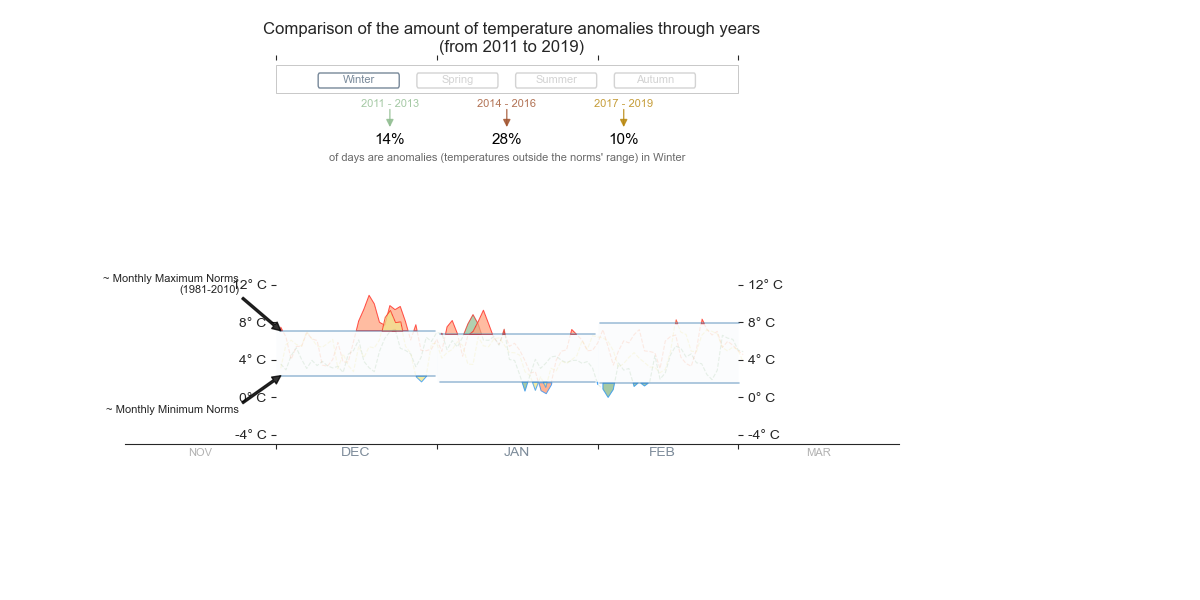

9

In [128]:
plt.figure(figsize=(10,5))

sns.set_style('ticks')

# plt.axis([-29, 120, -5, 36])

reset_axis()

Drawseason('Winter')

plt.gcf().canvas.mpl_connect('button_press_event', onclick) 

In [129]:
plt.savefig('Anomalies.jpg')